In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import copy
import time
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import StandardScaler

from evolution import model

In [2]:
featuremat = np.load('data/training_data/featurematrix_v2.npy')
time_to_failure_vec = np.load('data/training_data/time_to_failure.npy')
testmat = np.load('data/test_processed/featurematrix_test.npy')

In [3]:
trainset = np.random.choice(np.arange(len(time_to_failure_vec)),size=int(len(time_to_failure_vec)*.9),replace=False)
validationset = list(set(np.arange(len(time_to_failure_vec)))-set(trainset))

In [4]:
trainmat = featuremat[trainset,:]
validationmat = featuremat[validationset,:]

time_to_failure_train = time_to_failure_vec[trainset]
time_to_failure_validation = time_to_failure_vec[validationset]

## Normalise data

In [5]:
scaler = StandardScaler()
scaler.fit(trainmat)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [6]:
trainmat_scale = scaler.transform(trainmat)
validationmat_scale = scaler.transform(validationmat)

# Evolution

In [71]:
generations = 500
pop_size = 256
epochs = 100
batch_size = 64
num_all_features = featuremat.shape[1]

savepath = '/Users/djustus/workspace/earthquake/ckpt/'
model_name = 'E3-256_all_features'

### Create models with one hidden layer (with 1-64 units) each

In [72]:
model_list = []
for i in range(pop_size):
    model_list.append(model(featureset={np.random.choice(range(num_all_features))},
                            layerlist=[np.random.randint(1,64)],
                            dropoutlist=[0],
                            reg_constant=0.005,
                            learning_rate=0.01,
                            lr_decay=0.001,
                            num_all_features=num_all_features))

In [73]:
gen = -1

In [104]:
def train_model(model_list,trainmat,time_to_failure_train,validationmat,time_to_failure_validation,model_ind):
    
    trainmat_use = trainmat[:,list(model_list[model_ind].featureset)]
    validationmat_use = validationmat[:,list(model_list[model_ind].featureset)]

    m = model_list[model_ind].build()
    
    opt = tf.keras.optimizers.Adam(lr=model_list[model_ind].learning_rate,decay=model_list[model_ind].lr_decay)
    m.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])
    hist = m.fit(trainmat_use, 
          time_to_failure_train, 
          validation_data=(validationmat_use,time_to_failure_validation), 
          epochs=epochs, 
          batch_size=batch_size,
          verbose=0
         )
        
    loss = hist.history['val_mean_absolute_error'][-1]
    return loss

In [75]:
num_cores = multiprocessing.cpu_count()

## Training
Train generation 0 completely.  
Following generation 1: Train only mutations

In [110]:
loss = np.zeros([generations,pop_size])
born = np.zeros(pop_size)
id_hist = [str(n) for n in range(pop_size)]

models_employed = []
while gen<generations:
    gen+=1
    num_features_gen = []
    num_layers_gen = []
    t = time.time()
    
    models_employed.append(model_list) 
    
    for model_ind in range(pop_size):
        num_features_gen.append(model_list[model_ind].num_features)
        num_layers_gen.append(model_list[model_ind].num_layers)
        
    loss_generation = Parallel(n_jobs=num_cores)(
            delayed(train_model)(model_list,
                                 trainmat_scale,
                                 time_to_failure_train,
                                 validationmat_scale,
                                 time_to_failure_validation,
                                 model_ind) 
            for model_ind in range(int(pop_size/2),pop_size)
    )
#     loss_generation = [train_model(model_list,trainmat_scale,validationmat_scale,model_ind) 
#                        for model_ind in range(pop_size)]
    loss_generation = [1e9 if np.isnan(val) else val for val in loss_generation]
    
    if gen==0:
        loss_survivor = Parallel(n_jobs=num_cores)(
            delayed(train_model)(model_list,
                                 trainmat_scale,
                                 time_to_failure_train,
                                 validationmat_scale,
                                 time_to_failure_validation,
                                 model_ind) 
            for model_ind in range(0,int(pop_size/2))
        )
        loss_survivor = [1e9 if np.isnan(val) else val for val in loss_survivor]
            
    loss[gen,0:int(pop_size/2)] = loss_survivor
    loss[gen,int(pop_size/2):pop_size] = loss_generation
    
    tf.keras.backend.clear_session()    
        
    survive = np.argsort(born)[int(pop_size/2):]
    parent = np.argsort(loss[gen,:])[0:int(pop_size/2)]
    best = parent[0]
    
    print('Generation %d finished, %.3f sec,\n'
          'average number of features %.1f, average number of layers %.1f, average loss %.3f, \n'          
          'best features %s, best number of layers %.1f, best loss %.3f'
          %(gen, time.time()-t, 
            np.mean(num_features_gen), np.mean(num_layers_gen), np.mean(loss[gen,:]), 
            model_list[best].featureset, model_list[best].num_layers, loss[gen,best]))
    
    model_list2 = []
    born2 = []
    id_hist2 = []
    loss_survivor = []
    for model_ind in survive:
        model_list2.append(model_list[model_ind])
        loss_survivor.append(loss[gen,model_ind])
        born2.append(born[model_ind])
        id_hist2.append(id_hist[model_ind])
    for model_ind in parent:
        mutation = copy.deepcopy(model_list[model_ind])
        mutation.mutate()
        model_list2.append(mutation)
        born2.append(time.time())
        id_hist2.append(id_hist[model_ind]+','+str(model_ind))
        
    born = born2
    model_list = model_list2
    id_hist = id_hist2
    with open(os.path.join(savepath,'model_list_%s_gen%d.pkl' %(model_name,gen)),'wb') as fn:
        pickle.dump(model_list,fn)

KeyboardInterrupt: 

In [111]:
for i in range(pop_size):
    print(model_list[i].featureset)

{10, 26, 14}
{10, 12, 31}
{11, 10, 26}
{10, 26, 12}
{3, 10, 26, 12}
{26, 10, 35, 12}
{10, 26, 12}
{10, 26, 12}
{35, 10, 26, 12}
{25, 10, 12}
{10, 3, 36}
{10, 12}
{32, 10, 12, 26, 29}
{35, 10, 26, 12}
{10, 12}
{10, 11, 31}
{33, 4, 10, 12, 20}
{10, 12}
{26, 10, 35, 12}
{35, 10, 26, 12}
{8, 10, 11}
{25, 10, 12}
{11, 2, 10}
{26, 10, 35, 12}
{10, 12}
{10, 26, 11}
{10, 12, 13}
{32, 10, 12, 26, 29}
{10, 12}
{2, 10, 11}
{10, 12}
{10, 11, 31, 23}
{10, 26, 36}
{10, 12}
{32, 10}
{10, 26, 11}
{32, 10, 12}
{10}
{32, 10}
{10, 11}
{32, 10, 30}
{32, 10, 30}
{10, 3, 36}
{10}
{32, 10, 30}
{32, 10, 30}
{32, 10, 23}
{32, 10}
{9, 10, 30}
{32, 1, 10, 15}
{10}
{32, 10, 3}
{10, 12}
{32, 10}
{10, 30}
{30}
{32, 10, 23}
{10, 26}
{10, 12}
{32, 10}
{32, 10, 30}
{10}
{32, 10, 30}
{27, 10, 18}
{12}
{10, 30}
{9, 10, 19}
{32, 1, 37, 10, 30}
{32, 10}
{10, 30}
{3}
{10, 30}
{10, 35, 30}
{32, 10}
{8, 10}
{32, 1, 10}
{32, 10, 30}
{10}
{10}
{24, 10}
{32, 10}
{32}
{32, 10, 30}
{32, 10, 30}
{10, 3}
{10, 26}
{10, 2, 6}
{26, 10

In [ ]:
np.argmin(loss[gen-1])

In [ ]:
best_model=model_list[0]

In [ ]:
best_model.layerlist

In [ ]:
m = best_model.build()

In [ ]:
trainmat_use = trainmat[:,list(best_model.featureset)]
validationmat_use = validationmat[:,list(best_model.featureset)]

opt = tf.keras.optimizers.Adam(lr=0.01,decay=.1)
m.compile(optimizer=opt,
          loss='mean_squared_error',
          metrics=['mean_absolute_error'])
hist = m.fit(trainmat_use,
             time_to_failure_train, 
             validation_data=(validationmat_use,time_to_failure_validation), 
             epochs=1000, 
             batch_size=batch_size
            )

In [ ]:
best_model.learning_rate

In [80]:
featurecount = np.zeros(num_all_features)

In [107]:
for i in range(256):
    for f in model_list[i].featureset:
        featurecount[f] = featurecount[f]+1

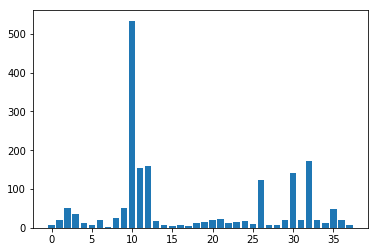

In [108]:
plt.bar(np.arange(38),featurecount)
plt.show()